In [1]:
import open3d as o3d
import numpy as np
import copy
import cv2
import matplotlib.pyplot as plt
import os

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [1233]:
# Load the meshes
mesh_name = "003702" # must be 4 digits: xx01 indicates lower jaw, xx02 indicates upper jaw
save_dir = f"D:\sunny\Codes\DPS\data_png"
origin_file_path = f"D:\sunny\Codes\DPS\data_teethseg\origin\{mesh_name}_origin.ply"
label_file_path = f"D:\sunny\Codes\DPS\data_teethseg\label\{mesh_name}.ply"
raw_origin_mesh = o3d.io.read_triangle_mesh(origin_file_path)
raw_label_mesh = o3d.io.read_triangle_mesh(label_file_path)
# Remove duplicated triangles of the meshes
raw_origin_mesh.remove_duplicated_triangles()
raw_label_mesh.remove_duplicated_triangles()


axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=20, origin=[0,0,0])

In [1234]:
# Find two end points of the intraoral mesh by the max and min theta values
def find_key_points(mesh):
    vertices = np.asarray(mesh.vertices)
    x,y,z = vertices[:,0], vertices[:,1], vertices[:,2]
    theta = np.arctan2(z,x) + np.pi/2
    theta = np.where(theta<0, theta+2*np.pi, theta) # if theta < 0, add 2pi to make it positive
    endpt1 = vertices[np.argmin(theta)]
    endpt2 = vertices[np.argmax(theta)]
    # shift both endpts to x-z plane (i.e.y=0)
    endpt1[1] = 0
    endpt2[1] = 0
    centre = (endpt1 + endpt2) / 2
    return endpt1, endpt2, centre

# Recentre the mesh with centre keypoint at the origin, rotate the mesh about y axis such that x-axis point to endpt1
def recentre_mesh(mesh):
    mesh_rc = copy.deepcopy(mesh)
    
    endpt1, endpt2, centre_keypt = find_key_points(mesh)
    vertices = np.asarray(mesh.vertices)
    vertices = vertices - centre_keypt
    endpt1 = endpt1 - centre_keypt
    endpt2 = endpt2 - centre_keypt


    # Rotate the mesh about y axis such that x-axis point to endpt1
    theta = np.arctan2(endpt1[2], endpt1[0])
    # print(f"endpt1: {endpt1}, endpt2: {endpt2}, theta: {theta}")
    R = np.array([[np.cos(theta), 0, np.sin(theta)], [0, 1, 0], [-np.sin(theta), 0, np.cos(theta)]])
    vertices = np.dot(vertices, R.T)
    endpt1 = np.dot(endpt1, R.T)
    endpt2 = np.dot(endpt2, R.T)
    print(f"endpt1: {endpt1}, endpt2: {endpt2}")
    assert endpt1[2] < 1e-6, f"end point 1 {endpt1} is not on x-axis"
    assert endpt2[2] < 1e-6, f"end point 2 {endpt2} is not on x-axis"  

    mesh_rc.vertices = o3d.utility.Vector3dVector(vertices)
    return mesh_rc, endpt1, endpt2



# first translate mesh with its geometric center at origin
raw_origin_mesh.translate(-raw_origin_mesh.get_center())
# Then recenter the mesh with key points
origin_mesh, edp1, edp2 = recentre_mesh(raw_origin_mesh)
# recentre the label mesh with the same transformation
raw_label_mesh.translate(-raw_label_mesh.get_center())
label_mesh, _, _ = recentre_mesh(raw_label_mesh)

# Visualize the recentred mesh with key points, with axis drawn
pc = o3d.geometry.PointCloud()
pc.points = o3d.utility.Vector3dVector([edp1, edp2])
pc.paint_uniform_color([1, 0, 0])

o3d.visualization.draw_geometries([origin_mesh, axes, pc])

endpt1: [26.75752372  0.          0.        ], endpt2: [-2.67575237e+01  0.00000000e+00 -3.55271368e-15]
endpt1: [26.75752372  0.          0.        ], endpt2: [-2.67575237e+01  0.00000000e+00 -3.55271368e-15]


### 2.Mesh Separation

Utils + Upper Surface


In [1235]:
# Utils function


def set_difference(A, B):
    """ Return the elements in A but not in B"""
    A_view = A.view([('', A.dtype)] * A.shape[1])
    B_view = B.view([('', B.dtype)] * B.shape[1])
    C_view = np.setdiff1d(A_view, B_view)
    C = C_view.view(A.dtype).reshape(-1, A.shape[1])
    # print(f"initial size: {len(A)}, removed size: {len(B)}, final size: {len(C)}")
    return C



# Preserve connected vertices which belong to a big enough / biggest cluster (remove small disconnecting clusters)
def keep_large_component(mesh, max_only=False, min_size=600):
    """ Remove small disconnected components from the mesh
    Args:
        max_only: if True, only keep the biggest component
        min_size: only works if max_only is False, 
            in which case only components with size >= min_size are kept
        
    Return:
        mesh: the mesh with small components removed
        triangles: the preserved triangles of the mesh
        removed_triangles: the removed triangles of the mesh"""
    triangles = np.asarray(mesh.triangles)
    components = np.array(mesh.cluster_connected_triangles()[0])
    comp_sizes = np.bincount(components)
    if max_only: # only keep the biggest component
        max_comp_index = np.argmax(comp_sizes)
        large_comp_mask = components == max_comp_index

    else: # keep components with size >= min_size
        large_comp_indices = np.where(comp_sizes >= min_size)[0]
        large_comp_mask = np.isin(components, large_comp_indices)

    preserved_triangles = triangles[large_comp_mask]
    removed_triangles = triangles[np.logical_not(large_comp_mask)]
    mesh.triangles = o3d.utility.Vector3iVector(preserved_triangles) # update the mesh

    return mesh, preserved_triangles, removed_triangles


# Identify upward facing vertices (upper vertices) and visualize by coloring 

def extract_up_triangles(mesh, xpos_min=10, xpos_max=-10, 
                         ypos_min=-5, 
                         ynorm_min=0.5
                         ):
    """ All vertices are preserved. 
        Triangles with all 3 vertices upward facing are preserved"""

    triangles = np.asarray(mesh.triangles)
    vertices = np.asarray(mesh.vertices)
    normals = np.asarray(mesh.vertex_normals)
    
    assert xpos_min > xpos_max, "xpos_min must be greater than xpos_max: to avoid middle region"
    up_vert_xpos_mask = np.logical_or((vertices[:,0]) > xpos_min, (vertices[:,0]) < xpos_max)
    up_vert_ypos_mask = (vertices[:,1]) > ypos_min
    up_vert_norm_mask = normals[:,1] > ynorm_min
    up_vert_mask = up_vert_xpos_mask & up_vert_ypos_mask & up_vert_norm_mask 
    up_vert_mask =  up_vert_ypos_mask & up_vert_norm_mask 
    # print(np.sum(up_vert_mask))
    
    up_mesh = copy.deepcopy(mesh)
    up_triangles_mask = np.all(up_vert_mask[triangles], axis=1) # all 3 vertices of the triangle are upward facing
    up_triangles = triangles[up_triangles_mask]
    up_mesh.triangles = o3d.utility.Vector3iVector(up_triangles)

    up_mesh, up_triangles, _ = keep_large_component(up_mesh, min_size=600)
    unsampled_triangles = set_difference(triangles,up_triangles)
    unsampled_mesh = copy.deepcopy(mesh)
    unsampled_mesh.triangles = o3d.utility.Vector3iVector(unsampled_triangles)

    unsampled_mesh, unsampled_triangles, _ = keep_large_component(unsampled_mesh, min_size=500)

    # Triangles are either in up_triangles or unsampled_triangles
    up_triangles = set_difference(triangles, unsampled_triangles)
    assert abs(len(up_triangles) + len(unsampled_triangles) - len(triangles))<=1, "Triangles are not correctly separated"
    print(f"up_triangles: {len(up_triangles)}, unsampled_triangles: {len(unsampled_triangles)}")
    print(f"total triangles: {len(triangles)}")

    # up_mesh.triangles = o3d.utility.Vector3iVector(up_triangles)
    
    return up_triangles, unsampled_mesh

# Execution
up_triangles, unsampled_mesh = extract_up_triangles(origin_mesh)

# Visualize the upward facing triangles
visual_mesh_up = copy.deepcopy(origin_mesh)
visual_mesh_up.triangles = o3d.utility.Vector3iVector(up_triangles)
visual_mesh_up.paint_uniform_color([0, 1, 0])

o3d.visualization.draw_geometries([unsampled_mesh, visual_mesh_up, axes])




up_triangles: 17797, unsampled_triangles: 18394
total triangles: 36191


In [1236]:
""" Inner and Outer Surface Separation"""
# Separate the original mesh vertices into inward-facing and outward-facing vertices relative to the origin
# With original (non re-centered mesh)


def separate_io_triangles(mesh):
    """ Separate the original mesh triangles into 
    inward-facing and outward-facing triangles relative to the origin
    
    All vertices are preserved."""

    vertices = np.asarray(mesh.vertices)
    triangles = np.asarray(mesh.triangles)
    viewpt1 = np.mean(vertices, axis=0)
    vertices_vp1 = vertices - viewpt1
    viewpt2 = viewpt1 / 2
    vertices_vp2 = vertices - viewpt2

    normals = np.asarray(mesh.vertex_normals)

    # analyse the mesh in 3 parts (based on z coords)
    # each part has different viewpt for normal thresholding
    pos_mask1 = vertices[:, 2] > viewpt1[2]
    in_vert_mask1 = np.logical_and(np.sum(normals * vertices_vp1, axis=1) < 0, pos_mask1)
    pos_mask2 = np.logical_and(viewpt2[2] < vertices[:, 2], vertices[:, 2] < viewpt1[2])
    in_vert_mask2 = np.logical_and(np.sum(normals * vertices_vp2, axis=1) < 0, pos_mask2)
    pos_mask3 = vertices[:, 2] < viewpt2[2]
    in_vert_mask3 = np.logical_and(np.sum(normals * vertices, axis=1) < 0, pos_mask3)

    # merge the 3 masks
    in_vert_mask = in_vert_mask1 + in_vert_mask2 + in_vert_mask3

    # separate triangles
    in_triangles_mask = np.all(in_vert_mask[triangles], axis=1)
    in_triangles = triangles[in_triangles_mask]
    in_mesh = copy.deepcopy(mesh)
    in_mesh.triangles = o3d.utility.Vector3iVector(in_triangles)

    out_triangles_mask = ~in_triangles_mask
    out_triangles = triangles[out_triangles_mask]
    out_mesh = copy.deepcopy(mesh)
    out_mesh.triangles = o3d.utility.Vector3iVector(out_triangles)

    assert len(in_triangles) + len(out_triangles) == len(triangles), "Triangles are not correctly separated"

    # clean up
    in_mesh, in_triangles, in_to_out_triangles = keep_large_component(in_mesh, min_size=100)
    out_mesh, out_triangles, out_to_in_triangles = keep_large_component(out_mesh, min_size=100)

    # add out_to_in_triangles to in_triangles
    in_triangles = np.concatenate([in_triangles, out_to_in_triangles])
    out_triangles = np.concatenate([out_triangles, in_to_out_triangles])

    return in_triangles, out_triangles


in_triangles, out_triangles = separate_io_triangles(unsampled_mesh)

# check all triangles are accounted for
assert abs(len(in_triangles) + len(out_triangles) - len(np.asarray(unsampled_mesh.triangles)))<=1, "Sum of inward and outward triangles not equal to unsampled triangles"
# assert abs(len(up_triangles) + len(in_triangles) + len(out_triangles) - len(np.asarray(origin_mesh.triangles)))<=1, "Sum of upward, inward and outward triangles not equal to total triangles"
print(f"Upward triangles: {len(up_triangles)}, Inward triangles: {len(in_triangles)}, Outward triangles: {len(out_triangles)}")
print(f"Total triangles: {len(np.asarray(origin_mesh.triangles))}")

# Visualize overall separation
visual_mesh_in = copy.deepcopy(origin_mesh)
visual_mesh_in.triangles = o3d.utility.Vector3iVector(in_triangles)
visual_mesh_in.paint_uniform_color([0, 0, 1])

visual_mesh_out = copy.deepcopy(origin_mesh)
visual_mesh_out.triangles = o3d.utility.Vector3iVector(out_triangles)
visual_mesh_out.paint_uniform_color([1, 0, 0])

visual_mesh_up = copy.deepcopy(origin_mesh)
visual_mesh_up.triangles = o3d.utility.Vector3iVector(up_triangles)
visual_mesh_up.paint_uniform_color([0, 1, 0])

o3d.visualization.draw_geometries([visual_mesh_in, visual_mesh_out, visual_mesh_up, axes])


Upward triangles: 17797, Inward triangles: 4003, Outward triangles: 14391
Total triangles: 36191
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 句柄无效。 


### 3. Project 3D Mesh into 2D UV coordinates

In [1237]:

def UVmap_planar(vertices):
    """ UV mapping from xyz coordinates of upward-facing vertices
    Args:
        vertices: xyz coordinates of vertices

    Return:
        uv_coords: uv coordinates of vertices (u=x, v=z) 
        depth_map: projection depth = y_max - y"""

    uv_coords = vertices[:, [0, 2]]
    depth_map = vertices[:, 1] # larger y value means closer to the camera (rasterized later)

    return uv_coords, depth_map


def UVmap_cylindrical(vertices, if_inward=True):
    """ UV mapping from xyz coordinates of inward or outward facing vertices
    Args:
        vertices: xyz coordinates of vertices
        if_inward: if True, the vertices are inward facing, projection depth = xz_norm
                   if False, the vertices are outward facing = max(xz_norm) - xz_norm
        
    Return:
        uv_coords: uv coordinates of vertices (u=theta, v=y) 
        depth_map: projection depth"""

    uv_coords = []
    for i in range(vertices.shape[0]):
        x, y, z = vertices[i]
        theta = np.arctan2(z, x)

        # FIXME: only if mesh is geometrically centered at origin!!!!!!
        theta = theta + np.pi /2
        if theta < 0:
            theta = theta + 2 * np.pi
            
        y = y
        uv_coords.append([theta, y])

    depth_map = np.linalg.norm(vertices[:, [0, 2]], axis=1)
    if if_inward:
        depth_map = np.max(depth_map) - depth_map
    
    return np.array(uv_coords), depth_map



def normalize_uv_coords(uv_coords, u_range, v_range, with_nl=False):
    uv_norm_coords = np.copy(uv_coords)
    u_min, u_max = u_range
    v_min, v_max = v_range
    uv_norm_coords[:, 0] = (uv_coords[:, 0] - u_min) / (u_max - u_min)
    uv_norm_coords[:, 1] = (uv_coords[:, 1] - v_min) / (v_max - v_min)

    # non-linear transformation to reduce distortion in theta
    # set to True if the mesh is cylindrically projected
    # if with_nl: 
    #     x_coords = uv_norm_coords[:,0]
    #     y_coords = uv_norm_coords[:,1]
    #     x_coords_tf = np.sin((x_coords - 0.5) * np.pi) / 2 + 0.5
    #     uv_norm_coords_tf = np.stack([x_coords_tf, y_coords], axis=1)
    #     return uv_norm_coords_tf

    # else:
    return uv_norm_coords






''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
# Execution of UV projection (for all vertices in each of 3 cases)

# Get the vertices of the origin mesh
# vertices = np.asarray(origin_mesh.vertices)
origin_mesh_c = copy.deepcopy(origin_mesh)
origin_mesh_c.translate(-origin_mesh_c.get_center())
vertices = np.asarray(origin_mesh_c.vertices) # FIXME: origin at mesh geometrical center


# UV mapping for all vertices in 3 cases NOTE: all vertices are projected in each case!!!!!!
uv_out, vert_depth_out = UVmap_cylindrical(vertices, if_inward=False)
uv_in, vert_depth_in = UVmap_cylindrical(vertices, if_inward=True)
uv_up, vert_depth_up = UVmap_planar(vertices)


print(np.min(uv_out, axis=0), np.max(uv_out, axis=0))
print(np.min(uv_in, axis=0), np.max(uv_in, axis=0))
print(np.min(uv_up, axis=0), np.max(uv_up, axis=0))


# Normalize the uv coordinates
# uv_norm_out = normalize_uv_coords(uv_out, (0,2*np.pi), (-9, 7), with_nl=True)
# uv_norm_in = normalize_uv_coords(uv_in, (0,2*np.pi), (-8, 8), with_nl=True)
# uv_norm_up = normalize_uv_coords(uv_up, (-50,50), (-25, 25))

uv_norm_out = normalize_uv_coords(uv_out, (0, 2*np.pi), (-9, 7), with_nl=True)
uv_norm_in = normalize_uv_coords(uv_in, (0, 2*np.pi), (-8, 8), with_nl=True)
uv_norm_up = normalize_uv_coords(uv_up, (-45,45), (-30, 30))





''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
# Keep track of vertices which belong to each case out of all vertices
vertices = np.asarray(origin_mesh.vertices)


# Find unique vertex indices for each case
out_vert_idx = np.unique(out_triangles.flatten())
in_vert_idx = np.unique(in_triangles.flatten())
up_vert_idx = np.unique(up_triangles.flatten())


# Print lengths for verification
print(out_vert_idx.shape, in_vert_idx.shape, up_vert_idx.shape)
print(vertices.shape)





''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
# COLORS!!!!
vertices_originRGB_raw = np.asarray(origin_mesh.vertex_colors) # r,g,b within (0-1)
vertices_labelRGB_raw = np.asarray(label_mesh.vertex_colors) # black/grey/non-white >= (0,0,0) for plaque, white=(1,1,1) for non-plaque

# Convert RGB format into 0-255
# Flip plaque representation from dark (black or grey) to white
vertices_originRGB = (vertices_originRGB_raw * 255).astype(np.uint8) # 0-255
vertices_labelRGB = ((1-vertices_labelRGB_raw) * 255).astype(np.uint8) # 0-255, non-black>(0,0,0) for plaue, black=(0,0,0) for non-plaque




[ 0.833926   -8.02247857] [5.47462188 4.51152771]
[ 0.833926   -8.02247857] [5.47462188 4.51152771]
[-35.81605555 -26.5109547 ] [36.78296753 25.28719357]
(7782,) (2370,) (9461,)
(18571, 3)


### 4. Rasterize UV coordinates into pixel images

Image shape: (256, 2048, 3)
Image shape: (256, 2048, 3)
Image shape: (512, 768, 3)


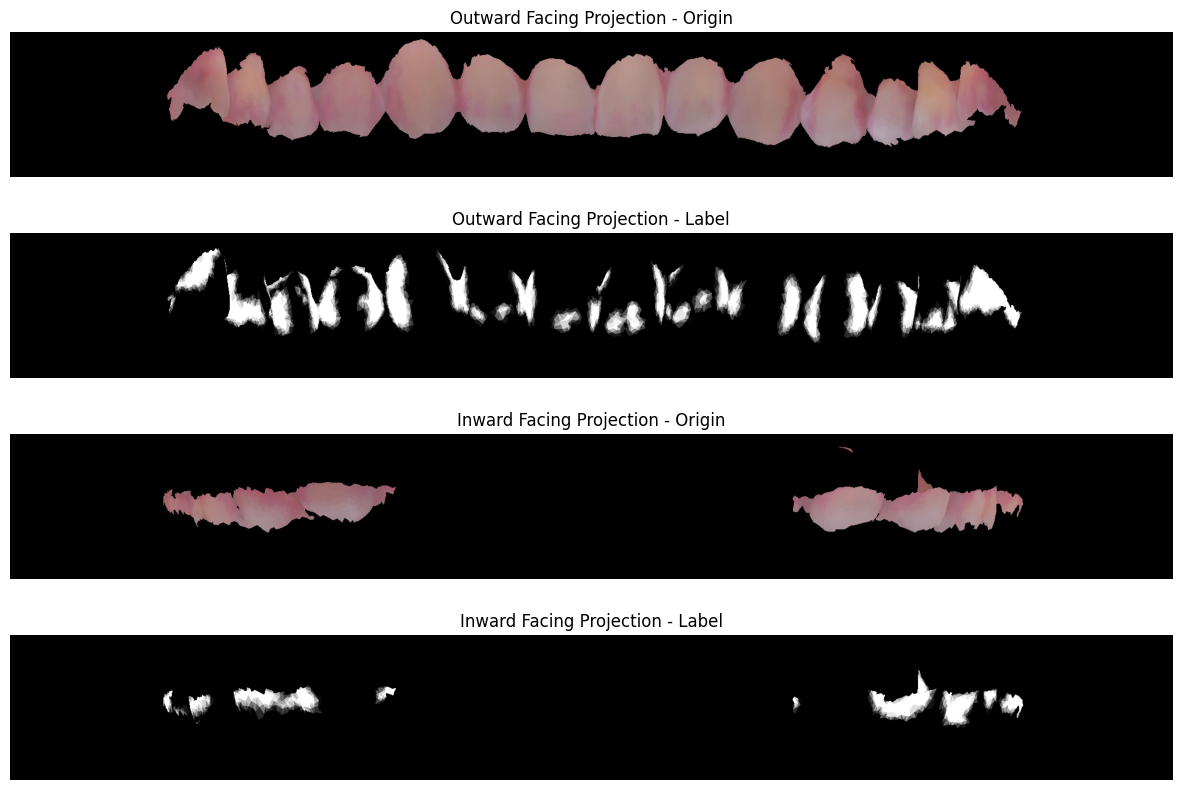

In [1238]:
def get_tri_RGB(triangles, vertex_RGB):
    """ Get the RGB of each triangle face from the RGB of its 3 vertices"""
    tri_RGBs = []
    for triangle in triangles:
        colors_3vert = vertex_RGB[triangle]
        # Get the minimum color value for each channel
        tri_rgb = np.mean(colors_3vert, axis=0) # TODO: min vs mean!!!!
        tri_RGBs.append(tri_rgb)
    return np.array(tri_RGBs)


def rasterize(sorted_tri, sorted_tri_RGB, uv_pixel, img):
    for i, tri in enumerate(sorted_tri):
        pts = uv_pixel[tri].reshape((-1, 1, 2)).astype(np.int32)
        tri_RGB = tuple(int(c) for c in sorted_tri_RGB[i]) # convert to tuple for cv2.fillPoly
        cv2.fillPoly(img, [pts], tri_RGB)
    return img




def rasterize_uv_to_image(uv_norm_coords, vert_depth, xx_triangles, vert_originRGB, vert_labelRGB, px=256, is_io=True):
    if is_io:
        px_h = px # 256
        px_w = px_h*8 # 2048
    else:
        px_h = px*2 # 512
        px_w = px*3 # 768
    
    # Scale uv_norm_coords by width and height to get pixel coordinates
    uv_pixel = np.copy(uv_norm_coords)
    uv_pixel[:, 0] = (uv_norm_coords[:, 0] * px_w-1).astype(np.int32)
    uv_pixel[:, 1] = (uv_norm_coords[:, 1] * px_h-1).astype(np.int32)

    # Calculate projection depth for each triangle face (mean projection depth of 3 vertices)
    tri_depth = np.mean(vert_depth[xx_triangles], axis=1)

    # Sort the triangles by depth (ascending)
    sorted_tri_idx = np.argsort(tri_depth)
    sorted_tri= xx_triangles[sorted_tri_idx]


    """ Get original colors and labels for each triangle face"""
    sorted_tri_originRGB = get_tri_RGB(sorted_tri, vert_originRGB)
    sorted_tri_labelRGB = get_tri_RGB(sorted_tri, vert_labelRGB)
    

    """ Rasterize the triangles in sorted order of depth"""
    # Initialize the image with black background
    img_origin = np.zeros((px_h, px_w, 3), dtype=np.uint8)
    img_label = np.zeros((px_h, px_w, 3), dtype=np.uint8)
    # Rasterize
    img_origin = rasterize(sorted_tri, sorted_tri_originRGB, uv_pixel, img_origin)
    img_label = rasterize(sorted_tri, sorted_tri_labelRGB, uv_pixel, img_label)

    print(f"Image shape: {img_origin.shape}")
    assert img_origin.shape == img_label.shape, "Origin and label images have different shapes"

    """ Simply return the entire complete image as a whole. 
        Use Patchify function to divide the image into 8 patches later before training"""
    # if is_io:
    #     """ Divide the image into 8 patches (horizontally) for inward/outward facing vertices"""
    #     img_origin_patches = np.array([img_origin[:, i*pxl:(i+1)*pxl] for i in range(8)])
    #     img_label_patches = np.array([img_label[:, i*pxl:(i+1)*pxl] for i in range(8)])



    # FIXME: Not sure whether to convert to binary label for training?????
    # if is_label_binary:
    #     img_label = np.where(img_label > 0, 1, 0).astype(np.uint8)

    return img_origin, img_label, uv_pixel # img: 3 RGB channel np arrays




img_origin_out, img_label_out, uv_pixel_out = rasterize_uv_to_image(uv_norm_out, vert_depth_out, out_triangles, vertices_originRGB, vertices_labelRGB, px=256, is_io=True)
img_origin_in, img_label_in, uv_pixel_in = rasterize_uv_to_image(uv_norm_in, vert_depth_in, in_triangles, vertices_originRGB, vertices_labelRGB, px=256, is_io=True)
img_origin_up, img_label_up, uv_pixel_up = rasterize_uv_to_image(uv_norm_up, vert_depth_up, up_triangles, vertices_originRGB, vertices_labelRGB, px=256, is_io=False)



# TODO: Inward / Outward projected images will be patched into 1x8
# TODO: Upward projected image will be patched into 2x4




# Visaulize the rasterized images
# Display the in- and outward large image for visualization
fig, ax = plt.subplots(4,1, figsize=(15, 10))

ax[0].imshow(img_origin_out)
ax[0].set_title("Outward Facing Projection - Origin")
ax[0].axis('off')


ax[1].imshow(img_label_out)
ax[1].set_title("Outward Facing Projection - Label")
ax[1].axis('off')

ax[2].imshow(img_origin_in)
ax[2].set_title("Inward Facing Projection - Origin")
ax[2].axis('off')

ax[3].imshow(img_label_in)
ax[3].set_title("Inward Facing Projection - Label")
ax[3].axis('off')

plt.show()


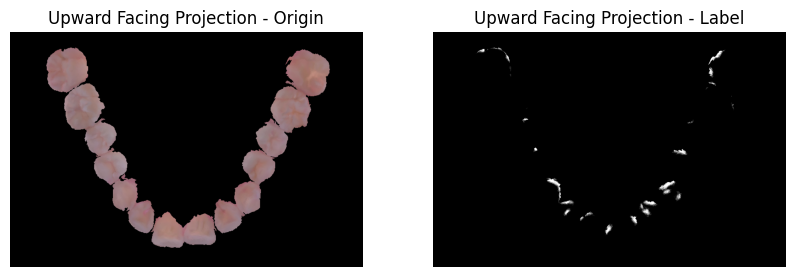

In [1239]:
# Display the large image for upward-facing visualization
fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].imshow(img_origin_up)
ax[0].set_title("Upward Facing Projection - Origin")
ax[0].axis('off')

ax[1].imshow(img_label_up)
ax[1].set_title("Upward Facing Projection - Label")
ax[1].axis('off')

plt.show()

In [1240]:

save_origin_path = os.path.join(save_dir, "origin")
save_label_path = os.path.join(save_dir, "label")


for idx, (img_origin_xx, img_label_xx) in enumerate(zip([img_origin_up, img_origin_in, img_origin_out], [img_label_up, img_label_in, img_label_out])):
    origin_bgr = cv2.cvtColor(img_origin_xx, cv2.COLOR_RGB2BGR)
    label_gray = cv2.cvtColor(img_label_xx, cv2.COLOR_RGB2GRAY)
    cv2.imwrite(os.path.join(save_origin_path, f"{mesh_name}_{idx}.png"), origin_bgr)
    cv2.imwrite(os.path.join(save_label_path, f"{mesh_name}_{idx}.png"), label_gray)

# Save UV pixel coordinates and separation of triangles information in npz format
reconst_info = {"uvpx_up": uv_pixel_up, "uvpx_in": uv_pixel_in, "uvpx_out": uv_pixel_out,
                "tri_up": up_triangles, "tri_in": in_triangles, "tri_out": out_triangles}
np.savez_compressed(os.path.join(save_dir, "info", f"{mesh_name}.npz"), **reconst_info)

### Test: Quality of UV mapping

Standardize RGB Format

- Range: [0-1]
- Black (0,0,0): Non-plaque
- White / Grey / Non-black > (0,0,0): Plaque

In [1241]:
################### For triangle labels ############################

# Predicted label image (GT as ideal case test) has flipped intensity (0 to 1, 1 to 0)
# In contrast, GT: vertices_labelRGB_raw are not flipped, RGB (0-1)

# Directly load the 2D label images above as the predicted label images (ideal case test)
# 0-1
pred_img_label_out = img_label_out/255  
pred_img_label_in = img_label_in/255
pred_img_label_up = img_label_up/255 



# For each direciton (outward, inward, upward):
# Find uv_pixel of each triangle face center
def get_tri_center_uv(triangles, uv_pixels):
    tri_center_uv = np.mean(uv_pixels[triangles], axis=1)
    return tri_center_uv

tri_uvpx_up = get_tri_center_uv(up_triangles, uv_pixel_up)
tri_uvpx_in = get_tri_center_uv(in_triangles, uv_pixel_in)
tri_uvpx_out = get_tri_center_uv(out_triangles, uv_pixel_out)

# Extract the color of each triangle face center from the predicted label image
# Need to execute for each direction (outward, inward, upward)
def get_tri_pred_label(tri_uvpx, pred_img_label):
    tri_pred_label = []
    px_h, px_w = pred_img_label.shape[:2]
    for uv in tri_uvpx:
        u, v = uv.astype(np.int32)
        u = np.clip(u, 0, px_w-1)
        v = np.clip(v, 0, px_h-1)
        tri_pred_label.append(pred_img_label[v, u])
    return np.array(tri_pred_label)

tri_pred_label_up = get_tri_pred_label(tri_uvpx_up, pred_img_label_up)
tri_pred_label_in = get_tri_pred_label(tri_uvpx_in, pred_img_label_in)
tri_pred_label_out = get_tri_pred_label(tri_uvpx_out, pred_img_label_out)

# Get the GT label for each triangle face
tri_GT_labelGRB_up = get_tri_RGB(up_triangles, vertices_labelRGB)/255
tri_GT_labelGRB_in = get_tri_RGB(in_triangles, vertices_labelRGB)/255
tri_GT_labelGRB_out = get_tri_RGB(out_triangles, vertices_labelRGB)/255


def compute_metrics_tri(gt_labels, pred_labels):
    """ Compute the IoU and Dice scores for the triangles """
    # Convert RGB to binary scalar
    gt_labels_bi = np.any(gt_labels > 0, axis=1).astype(np.int32)
    pred_labels_bi = np.any(pred_labels > 0, axis=1).astype(np.int32)
    if np.sum(pred_labels) <=20: # FIXME: to check
        print("No predicted label")
        return 1, 1

    intersection = np.sum(np.logical_and(gt_labels, pred_labels))
    union = np.sum(np.logical_or(gt_labels, pred_labels))
    iou = intersection / union

    intersection_bi = np.sum(np.logical_and(gt_labels_bi, pred_labels_bi))
    dice = 2 * intersection_bi / (np.sum(gt_labels_bi) + np.sum(pred_labels_bi))
    # if non-binary (3 channel)
    # dice = 2/3 * intersection / (np.sum(np.any(gt_labels!=0,axis=1)) + np.sum(np.any(pred_labels!=0,axis=1)))
    return iou, dice



# Compare the predicted labels with the ground truth labels for all triangle faces
metrics_up = compute_metrics_tri(tri_GT_labelGRB_up, tri_pred_label_up)
metrics_in = compute_metrics_tri(tri_GT_labelGRB_in, tri_pred_label_in)
metrics_out = compute_metrics_tri(tri_GT_labelGRB_out, tri_pred_label_out)

print(f"Upward: IoU: {metrics_up[0]:.3f}, Dice: {metrics_up[1]:.3f}")
print(f"Inward: IoU: {metrics_in[0]:.3f}, Dice: {metrics_in[1]:.3f}")
print(f"Outward: IoU: {metrics_out[0]:.3f}, Dice: {metrics_out[1]:.3f}")


iou_mean = (metrics_up[0] + metrics_in[0] + metrics_out[0]) / 3
dice_mean = (metrics_up[1] + metrics_in[1] + metrics_out[1]) / 3
print(f"Mean IoU: {iou_mean:.3f}, Mean Dice: {dice_mean:.3f}")

Upward: IoU: 0.921, Dice: 0.959
Inward: IoU: 0.906, Dice: 0.951
Outward: IoU: 0.836, Dice: 0.911
Mean IoU: 0.887, Mean Dice: 0.940


In [1242]:
################### For vertex labels ############################
""" GT labels for the vertices (0-1) flipped """
vertices = np.asarray(origin_mesh.vertices)
vert_GT_label = 1 - vertices_labelRGB_raw # RGB for each vertex (with non-0 being plaque)

triangles = np.asarray(origin_mesh.triangles)
tri_GT_label = get_tri_RGB(triangles, vert_GT_label) # RGB for each triangle face (with non-0 being plaque)


# Initialize pred labels for vertices and triangles filled with -1
vert_pred_label = np.full((vertices.shape[0], 3), -1.0)
tri_pred_label = np.full((triangles.shape[0], 3), -1.0)

# check uv_pixel in all 3 cases include all vertices
assert uv_pixel_in.shape[0] == len(vertices), "Number of inward vertices do not match"
assert uv_pixel_out.shape[0] == len(vertices), "Number of outward vertices do not match"
assert uv_pixel_up.shape[0] == len(vertices), "Number of upward vertices do not match"



def update_uv_pred_label(vert_pred_label, uv_pixel, vert_idx, pred_img_label):
    """ Get the predicted label for each vertex UV pixel coordinate 
    located on the respective predicted label image"""
    px_h, px_w = pred_img_label.shape[:2]
    for idx in vert_idx: # idx among all vertices (since uv_pixel is for all vertices)
        u, v = uv_pixel[idx]
        u = np.clip(int(u), 0, px_w-1)
        v = np.clip(int(v), 0, px_h-1)
        
        # if pred_img_label[v, u].any() != 0 and pred_img_label[v,u].any()!=1: # if not black nor white
        #     print(f"pred_img_label: {pred_img_label[v,u]}")
        
        # if vert_pred_label[idx].all() == np.array([-1,-1,-1]).all():
        vert_pred_label[idx] = pred_img_label[v, u]
      
        # else:
            # vert_pred_label[idx] = (pred_img_label[v, u] + vert_pred_label[idx]) /2 # average if already assigned
    return vert_pred_label


# Update the predicted labels for each vertex (outward, inward, upward)
vert_pred_label = update_uv_pred_label(vert_pred_label, uv_pixel_out, out_vert_idx, pred_img_label_out)
vert_pred_label = update_uv_pred_label(vert_pred_label, uv_pixel_in, in_vert_idx, pred_img_label_in)
vert_pred_label = update_uv_pred_label(vert_pred_label, uv_pixel_up, up_vert_idx, pred_img_label_up)


# Convert both GT and pred labels to binary scalar (0 or 1)
vert_pred_label_binary= np.zeros(vert_pred_label.shape[0])
vert_pred_label_binary[np.any(vert_pred_label > 0.5, axis=1)] = 1

vert_GT_label_binary= np.zeros(vert_GT_label.shape[0])
vert_GT_label_binary[np.any(vert_GT_label > 0.5, axis=1)] = 1



assert len(vert_GT_label) == len(vert_pred_label), "Number of vertices in GT and pred labels do not match"



# Compare the predicted labels with the ground truth labels for all vertices from the entire mesh
def compute_metrics(gt_labels, pred_labels):
    """ Compute the IoU and Dice scores for the vertices """
    intersection = np.sum(np.logical_and(gt_labels, pred_labels))
    union = np.sum(np.logical_or(gt_labels, pred_labels))
    iou = intersection / union
    dice = 2 * intersection / (np.sum(gt_labels) + np.sum(pred_labels))
    # if non-binary (3 channel)
    # dice = 2/3 * intersection / (np.sum(np.any(gt_labels!=0,axis=1)) + np.sum(np.any(pred_labels!=0,axis=1)))
    return iou, dice

iou, dice = compute_metrics(vert_GT_label_binary, vert_pred_label_binary)
# iou_, dice_ = compute_metrics(vert_GT_label, vert_pred_label)

print(f"IoU: {iou:.4f}, Dice: {dice:.4f}")
# print(f"IoU: {iou_:.4f}, Dice: {dice_:.4f}")




# visualize the predicted label images in mesh form
def visualize_pred_labels(GTlabel_mesh, vert_GT_label_binary, vert_pred_label_binary): # assume vertex_pred_labels is in RGB format (0-1) non-binary
    """ Visualize the predicted labels on the mesh """
    mesh_pred = copy.deepcopy(GTlabel_mesh)
    vertices = np.asarray(mesh_pred.vertices)
    triangles = np.asarray(mesh_pred.triangles)
    colors = np.full((len(vertices), 3), 0.8) # grey: True negative

    
    for i in range(len(vertices)):
        if vert_pred_label_binary[i] == 1: 
            if vert_GT_label_binary[i] == 1: # True positive
                colors[i] = np.array([0, 1, 0]) # Green

            else: # False positive 误检
                colors[i] = np.array([0, 0, 0]) # Black
                
        else:
            if vert_GT_label_binary[i] == 1: # False negative 漏检
                colors[i] = np.array([1, 0, 0]) # Red

        
    mesh_pred.vertex_colors = o3d.utility.Vector3dVector(colors)

    return mesh_pred

mesh_pred = visualize_pred_labels(label_mesh, vert_GT_label_binary, vert_pred_label_binary)

o3d.visualization.draw_geometries([mesh_pred, axes])

IoU: 0.7309, Dice: 0.8445
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 不支持请求的转换操作。 


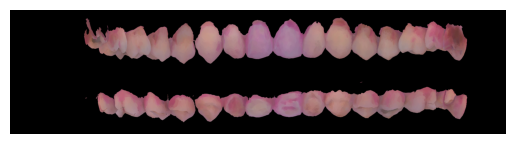

In [418]:
# # load npy file into images for visualization
# test_img_ary = np.load("D:\sunny\Codes\DPS\data_npy2d\origin\\001002.npy")

# # Create an empty array to hold the composite image
# composite_image = np.zeros((2 * 256, 8 * 256, 3), dtype=test_img_ary.dtype)

# for i in range(2):
#     for j in range(8):
#         img_inx = i * 8 + j
#         composite_image[i * 256:(i + 1) * 256, j * 256:(j + 1) * 256] = test_img_ary[img_inx]

# def show_image(image_array):
#     plt.imshow(image_array)
#     plt.axis('off')  # Hide the axis
#     plt.show()

# show_image(composite_image)